## 0 Data Analysis

This notebook analyses the Romansh data by split and amount of text and audio per idiom.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
from tqdm import tqdm
from collections import defaultdict

The data can be obtained from the `romansh-data` folder. Then the constants are instantiated and some useful functions are defined.

In [2]:
DATA_PATH = "romansh-data"
FOLDER_NAMES = [folder for folder in os.listdir(DATA_PATH) if not folder.endswith(".tgz")]
SPLITS = ["train", "validated", "test"]

def get_idiom_name_by_folder(folder_name):
  name = (folder_name.split("-")[0])[2:]
  match name:
    case "sursilv":
      return "Sursilvan"
    case "surmiran":
      return "Surmiran"
    case "sutsilv":
      return "Sutsilvan"
    case "puter":
      return "Puter"
    case "vallader":
      return "Vallader"
    case _:
      return "RG"

def get_audio_duration(path):
    try:
        with sf.SoundFile(path) as f:
            return len(f) / f.samplerate
    except Exception as e:
        print(f"Could not read {path}: {e}")
        return 0.0

Then the data can be loaded into dataframes for the different metrics.

In [3]:
duration_stats = defaultdict(lambda: defaultdict(float))
utterance_counts = defaultdict(lambda: defaultdict(int))
word_counts = defaultdict(lambda: defaultdict(int))

for idiom_file in FOLDER_NAMES:
  idiom_path = os.path.join(DATA_PATH, idiom_file)

  if not os.path.isdir(idiom_path):
    print(f"⚠️ Missing idiom folder: {idiom_file}")
    continue

  idiom = get_idiom_name_by_folder(idiom_file)

  for split in SPLITS:
    tsv_path = os.path.join(idiom_path, f"{split}.tsv")
    clips_path = os.path.join(idiom_path, "clips")

    if not os.path.isfile(tsv_path):
      print(f"  ⚠️ Missing {split}.tsv")
      continue

    df = pd.read_csv(tsv_path, sep="\t")

    num_words = (
      df["sentence"]
        .astype(str)
        .apply(lambda x: len(x.split()))
        .sum()
    )
    word_counts[idiom][split] = num_words

    total_seconds = 0.0
    for rel_path in tqdm(df["path"], desc=f"  {split}", leave=False):
      audio_path = os.path.join(clips_path, rel_path)
      total_seconds += get_audio_duration(audio_path)

    duration_stats[idiom][split] = total_seconds / 3600.0
    utterance_counts[idiom][split] = len(df)

duration_df = pd.DataFrame(duration_stats).T.fillna(0)
count_df = pd.DataFrame(utterance_counts).T.fillna(0)
word_df = pd.DataFrame(word_counts).T.fillna(0)

  train:  31%|███       | 2167/7085 [00:00<00:00, 21668.06it/s]

After that we can visualize some stats about the data.


📊 Duration summary (hours):
           train  validated  test
Surmiran   25.33      25.84   0.5
Sutsilvan  16.91      17.41   0.5
Puter      24.87      25.37   0.5
RG         26.75      27.25   0.5
Vallader   30.14      30.65   0.5
Sursilvan  36.78      37.29   0.5


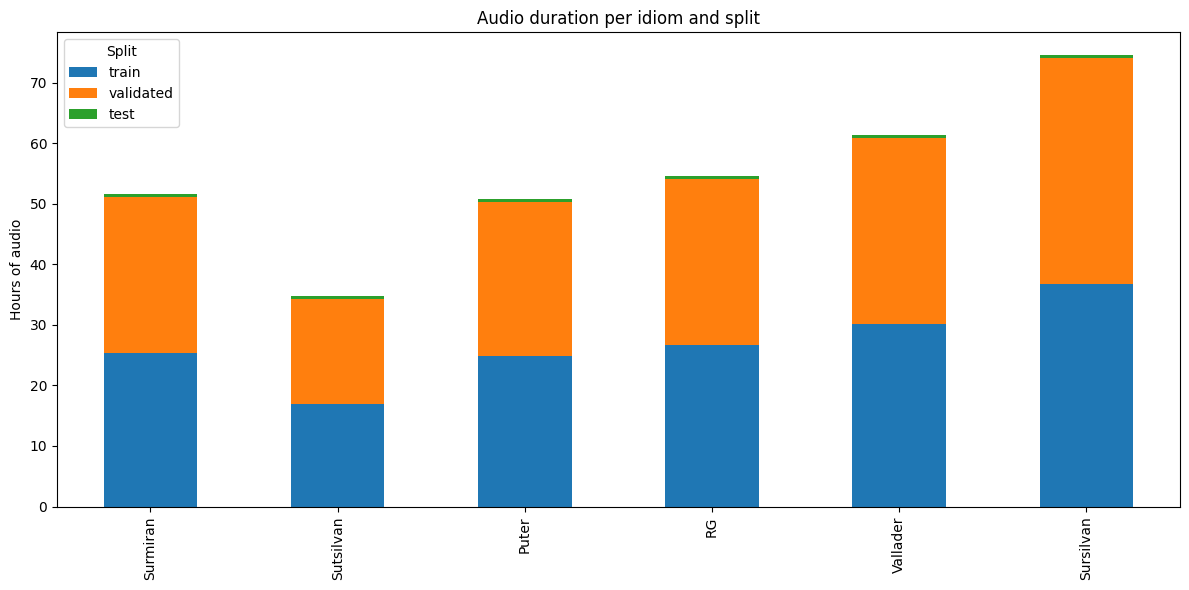


📚 Word count summary:
            train  validated   test
Surmiran   873055     890622  17567
Sutsilvan  153535     158177   4642
Puter      469848     479126   9278
RG         221364     225466   4102
Vallader   847055     861877  14822
Sursilvan  699814     707763   7949


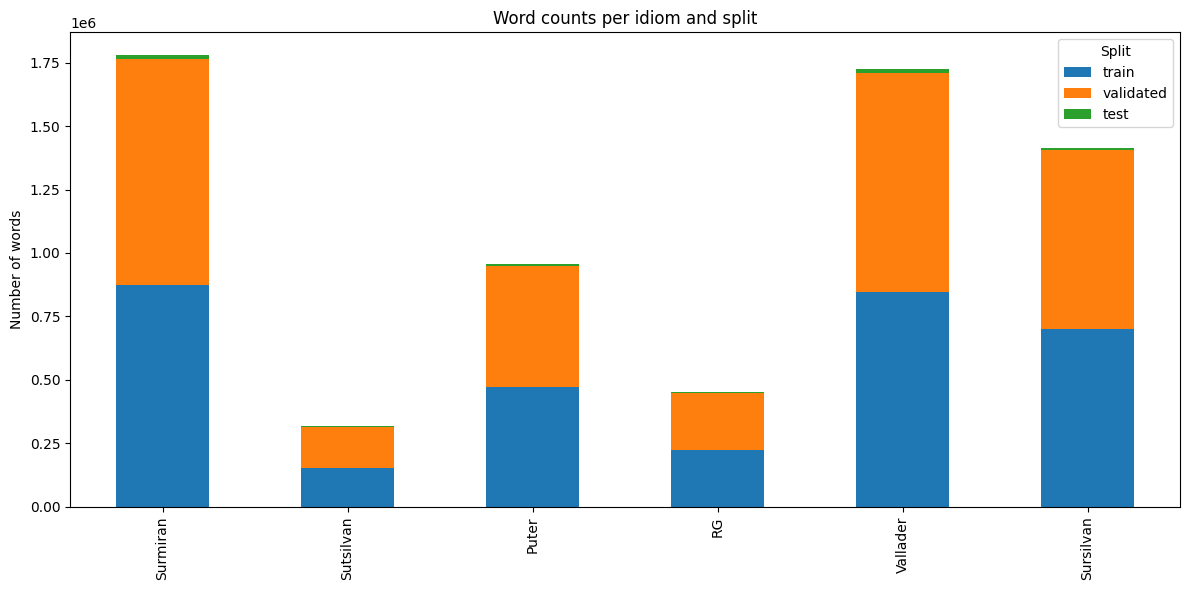


🗣 Utterance counts:
           train  validated  test
Surmiran    7085       7236   151
Sutsilvan   2991       3085    94
Puter       5917       6031   114
RG          4279       4360    81
Vallader    5693       5790    97
Sursilvan   6888       6982    94


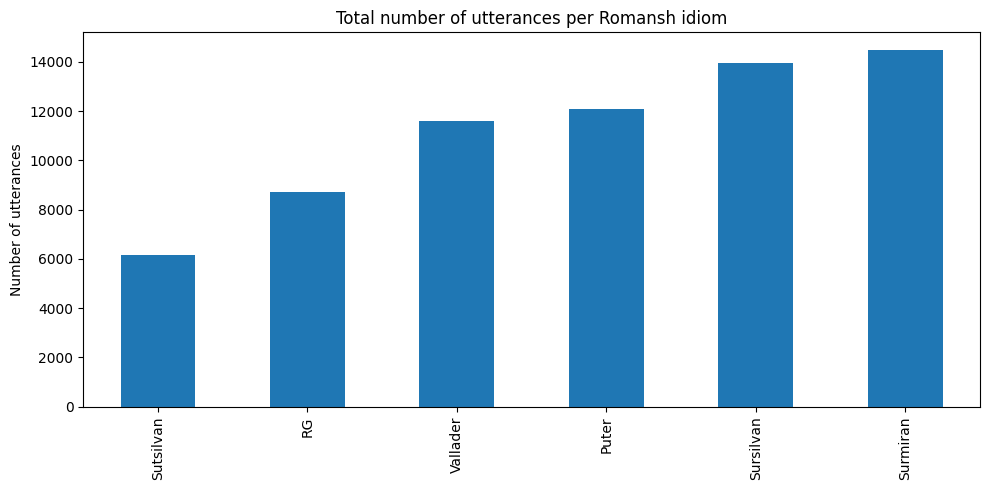

In [4]:
# Hours per split per idiom
print("\n📊 Duration summary (hours):")
print(duration_df.round(2))
duration_df.plot(
  kind="bar",
  stacked=True,
  figsize=(12, 6)
)
plt.ylabel("Hours of audio")
plt.title("Audio duration per idiom and split")
plt.legend(title="Split")
plt.tight_layout()
plt.show()

# Words per split per idiom
print("\n📚 Word count summary:")
print(word_df.astype(int))
word_df.plot(
  kind="bar",
  stacked=True,
  figsize=(12, 6)
)
plt.ylabel("Number of words")
plt.title("Word counts per idiom and split")
plt.legend(title="Split")
plt.tight_layout()
plt.show()

# Utterance counts
print("\n🗣 Utterance counts:")
print(count_df.astype(int))
count_df.sum(axis=1).sort_values().plot(
  kind="bar",
  figsize=(10, 5)
)
plt.ylabel("Number of utterances")
plt.title("Total number of utterances per Romansh idiom")
plt.tight_layout()
plt.show()